In [1]:
import pandas
import glob
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Path to images and jsons
data_path = 'data'

### Class for clustering

In [3]:
class ShelveClusterer:
    def __init__(self, distance_threshold, linkage, alpha_x, alpha_y, alpha_width, alpha_height):
        
        # Clustering parameters
        self.distance_threshold = distance_threshold
        self.linkage = linkage
        
        # Feature 'weight' parameters
        self.alpha_x = alpha_x
        self.alpha_y = alpha_y
        self.alpha_width = alpha_width
        self.alpha_height = alpha_height
        
    def get_clusters(self, data_in):
        
        data = data_in.copy()
        data = self.add_features(data)
        data['labels'] = self.calculate_clusters(data)
        
        return data['labels']
        
    def add_features(self, data):
        # Get centers and shapes
        data['center_x'] = data.apply(lambda row: (row.boxes[2] + row.boxes[0])/2, axis=1)
        data['center_y'] = data.apply(lambda row: (row.boxes[3] + row.boxes[1])/2, axis=1)
        data['width'] = data.apply(lambda row: row.boxes[2] - row.boxes[0], axis=1)
        data['height'] = data.apply(lambda row: row.boxes[3] - row.boxes[1], axis=1)
        
        # Normalize features and apply coefficients
        x_min, x_max = data['center_x'].min(), data['center_x'].max()
        y_min, y_max = data['center_y'].min(), data['center_y'].max()
        w_min, w_max = data['width'].min(), data['width'].max()
        h_min, h_max = data['height'].min(), data['height'].max()
        
        data['center_x'] = ((data['center_x'] - x_min)/(x_max - x_min)) * self.alpha_x
        data['center_y'] = ((data['center_y'] - y_min)/(y_max - y_min)) * self.alpha_y
    
        data['width'] = ((data['width'] - w_min)/(w_max - w_min)) * self.alpha_width
        data['height'] = ((data['height'] - h_min)/(h_max - h_min)) * self.alpha_height
        return data
    
    def calculate_clusters(self, data):    
        clustering = AgglomerativeClustering(
                                             n_clusters=None,
                                             affinity='euclidean',
                                             compute_full_tree=True,
                                             linkage=self.linkage,
                                             distance_threshold=self.distance_threshold
                                            ).fit(data[['center_y', 'center_x', 'width', 'height']])
        
        return clustering.labels_

In [4]:
# Make instance
clusterer = ShelveClusterer(distance_threshold=0.105,
                            linkage='average',
                            alpha_x=0.222, alpha_y=1.,
                            alpha_width=0.066,
                            alpha_height=0.066)

### Function for printing labels

In [5]:
def print_labels(img_in, boxes, labels, alpha=0.6, cmap_name='hsv'):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    overlay = img_in.copy()
    
    for (x0, y0, x1, y1), l in zip(boxes, labels):
        color = cmap(l/max(labels))
        color = (int(color[2]*255), int(color[1]*255), int(color[0]*255))

        x, y, w, h = int(x0), int(y0), int(x1-x0), int(y1-y0)  # Rectangle parameters
        cv2.rectangle(overlay, (x, y), (x+w, y+h), color, -1)  # Add filled and colored rectangle      

    # Merge img with overlay
    img_out = cv2.addWeighted(overlay, alpha, img_in, 1 - alpha, 0)
    return img_out

### Find some clusters

In [6]:
files_list = list(map(lambda x: (x, x[:-5]), glob.glob(os.path.join(os.getcwd(), data_path, '*.json'))))
print ('Number of images:', len(files_list))

processed_images = []

for json_path, jpeg_path in files_list:
    data = pandas.read_json(json_path)
    img = cv2.imread(jpeg_path)

    data['labels'] = clusterer.get_clusters(data)
    
    processed_images.append(print_labels(img, data['boxes'], data['labels']))

Number of images: 5


### Show results

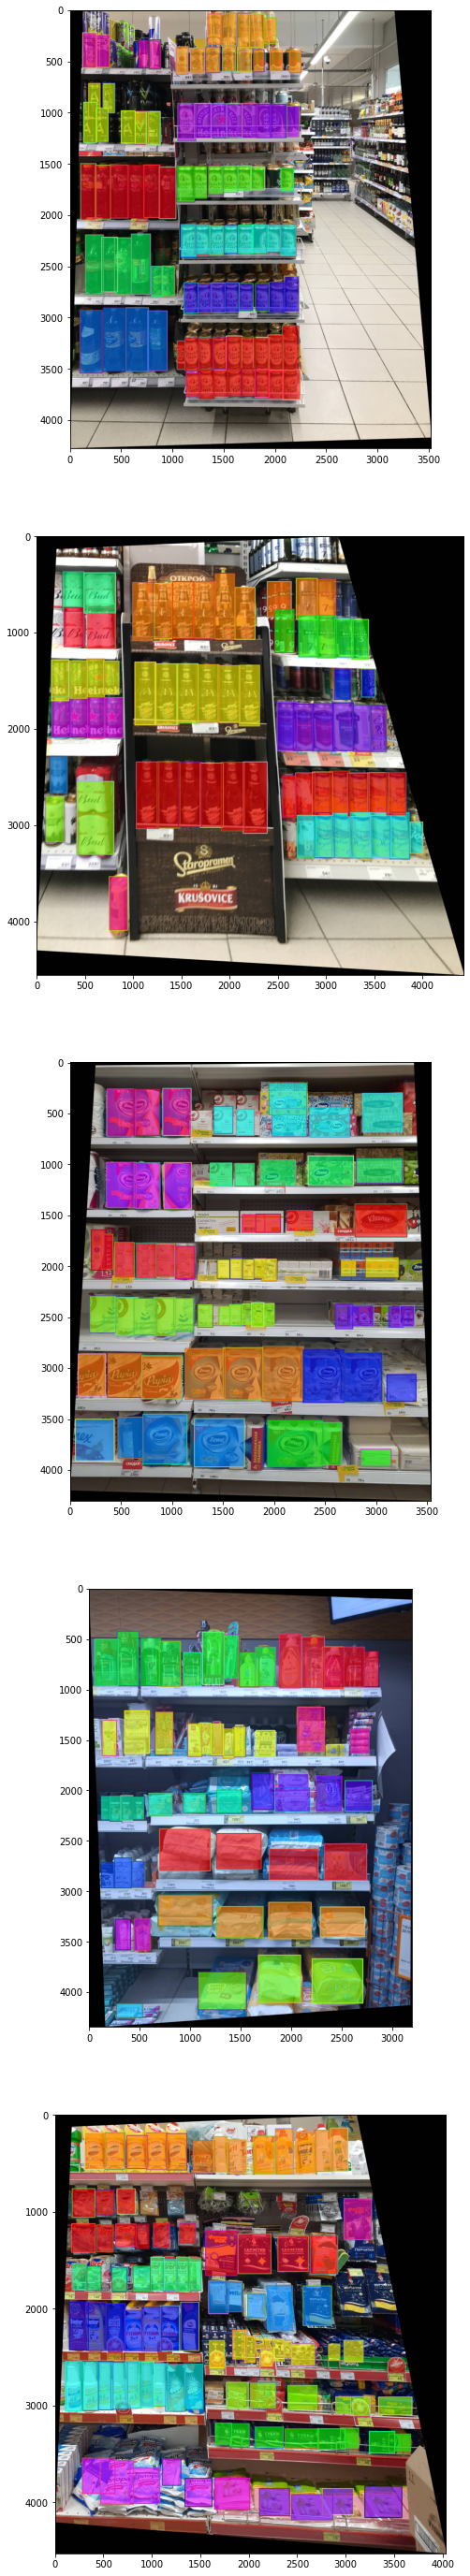

In [7]:
f, axs = plt.subplots(len(processed_images), 1, figsize = (10, 50))
for n, img_w_labels in enumerate(processed_images):
    axs[n].imshow(cv2.cvtColor(img_w_labels, cv2.COLOR_BGR2RGB))